# Scaling Elastic Wave Equations from Virieux 1986

In [2]:
# import dependencies
import devito as dv
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from examples.seismic.source import TimeAxis
from examples.seismic import RickerSource

### Implementing unscaled constant parameter propagation

In [79]:
# Set up the grid
extent = (2000, 2000)
shape = (201, 201)
x = dv.SpaceDimension('x')
z = dv.SpaceDimension('z')
grid = dv.Grid(extent=extent, shape=shape, dimensions=(x, z))

# Create the velocity and stress fields
v = dv.VectorTimeFunction(name='v', grid=grid, space_order=8, time_order=1)
tau = dv.TensorTimeFunction(name='tau', grid=grid, space_order=8, time_order=1)

# Define constants
constants = {
    "vp": 3,
    "vs": 1.5,
    "density": 2.4,
    "f0": 0.03
}

# Find dt using CFL condition
vmax = max(constants['vp'], constants['vs'])
dt = np.amin(grid.spacing) * 0.6 / vmax

# Define a time range for the source term
t0 = 0
tn = 250
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# Create the source term, f=0.03 kHz (30Hz)
src = RickerSource(name='src', grid=grid, f0=constants["f0"], npoint=1, time_range=time_range)

# Setting source to the middle of the grid
src.coordinates.data[:] = [1000., 1000.]

# Source term injections (include dt)
src_xx = src.inject(field=tau[0, 0].forward, expr=src * dt)
src_zz = src.inject(field=tau[1, 1].forward, expr=src * dt)

# Define equations (using finite-difference operators)
eq_vx = dv.Eq(v[0].dt, 1/constants['density'] * (tau[0, 0].dx + tau[0, 1].dz))
eq_vz = dv.Eq(v[1].dt, 1/constants['density'] * (tau[0, 1].dx + tau[1, 1].dz))

eq_sxx = dv.Eq(tau[0, 0].dt, constants['vp']**2 * constants['density'] * v[0].dx + (constants['vp']**2 - 2*constants['vs']**2) * constants['density'] * v[1].dz)
eq_szz = dv.Eq(tau[1, 1].dt, constants['vp']**2 * constants['density'] * v[1].dz + (constants['vp']**2 - 2*constants['vs']**2) * constants['density'] * v[0].dx)
eq_sxz = dv.Eq(tau[0, 1].dt, constants['vs']**2 * constants['density'] * (v[0].dz + v[1].dx))

# Define stencils
stencil_vx = dv.Eq(v[0].forward, dv.solve(eq_vx, v[0].forward))
stencil_vz = dv.Eq(v[1].forward, dv.solve(eq_vz, v[1].forward))
stencil_sxx = dv.Eq(tau[0, 0].forward, dv.solve(eq_sxx, tau[0, 0].forward))
stencil_szz = dv.Eq(tau[1, 1].forward, dv.solve(eq_szz, tau[1, 1].forward))
stencil_sxz = dv.Eq(tau[0, 1].forward, dv.solve(eq_sxz, tau[0, 1].forward))

# Set up the operator and run the simulation
op = dv.Operator([stencil_vx, stencil_vz, stencil_sxx, stencil_szz, stencil_sxz] + src_xx + src_zz)
op(dt=dt)


Operator `Kernel` ran in 0.08 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.07173700000000005, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

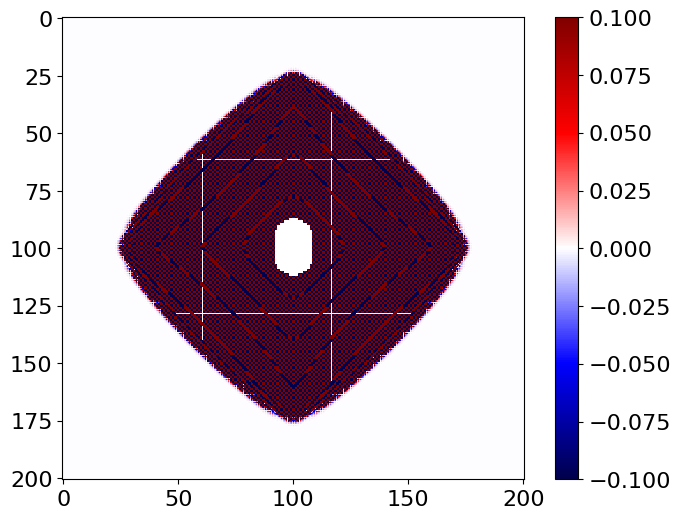

In [78]:
vmax = np.amax(np.abs(v[0].data[0]))
plt.imshow(v[0].data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

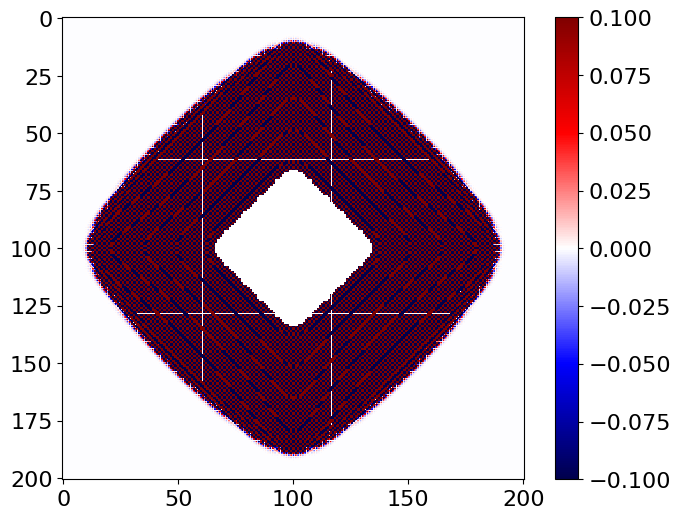

In [80]:
vmax = np.amax(np.abs(tau[0, 0].data[0]))
plt.imshow(tau[0, 0].data[0], cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()